In [1]:
### import packages ###
import numpy as np # for handling arrays
from lmfit import Minimizer, minimize, Parameters, report_fit, Model # for fitting data
from ipyfilechooser import FileChooser # for importing data
import matplotlib.pyplot as plt # for plotting data
import pandas as pd # for handling arrays and plotting data

In [2]:
### define required functions ###

# model for fitting
def biphasic_assoc_dissoc(x, coef_A, k_off1, k_off2, k_on1, k_on2, B1, B2, B3, B4, B5, B6):
    
    # split the x-data into association and dissociation data using the x_end_index.
    x_association = x[:x_end_index]
    # subtract the start point of dissociation so that t=0 when dissoc starts
    x_dissociation = np.subtract(x[x_end_index:],x[x_end_index])
    
    # create an empty array to fill with modeled y-data
    y_array = np.zeros((len(prot_conc_list), len(x)))
    
    # B_maxes are unlinked, assume that there are no more than 6 fits being performed
    B_list = [B1, B2, B3, B4, B5, B6]
    
    for i in range(len(prot_conc_list)):
        prot_conc = prot_conc_list[i]
        B_max = B_list[i]
        
        # generate the association data
        assoc = (coef_A*B_max*(1/(1+(k_off1/(k_on1*prot_conc))))*(1-np.exp(-(k_on1*prot_conc+k_off1)*x_association))+
                (1-coef_A)*B_max*(1/(1+(k_off2/(k_on2*prot_conc))))*(1-np.exp(-(k_on2*prot_conc+k_off2)*x_association)))
    
        # set the y_init_dis to be equal to the end of the association data
        y_init_dis = assoc[x_end_index-1]

        # generate the dissociation data
        dissoc = (coef_A * y_init_dis * np.exp(-1 * k_off1 * x_dissociation) 
                  + (1 - coef_A) * y_init_dis * np.exp(-1 * k_off2 * x_dissociation))

        # concatenate the association and dissocation
        assoc_dissoc = np.concatenate((assoc, dissoc))
        
        # fill the data into the empty y_array
        y_array[i,:] = assoc_dissoc
    
    # Flatten the y-data array into 1D. The fitting algorithm can't handle 2D data. 
    return y_array.flatten()

In [3]:
# Create and display a FileChooser widget to select the processed BLI data
fc = FileChooser()
display(fc)

FileChooser(path='/Users/benstordy/Library/CloudStorage/OneDrive-SharedLibraries-UniversityofToronto/Zahra Sep…

In [4]:
# get the file path of the selected BLI file
file_path=str(fc.selected)
# get the parent folder the file is in
folder_path = file_path[:file_path.rfind('/')+1]
# create a pandas dataframe with the BLI data
bli_data = pd.read_csv(file_path)
title = file_path[file_path.rfind('/')+1:file_path.rfind('.')]

<Axes: xlabel='Time'>

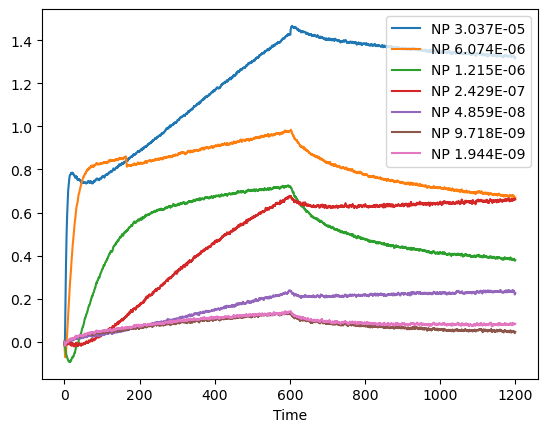

In [5]:
# plot the full dataset to select columns for fitting
bli_data.plot(x='Time')

In [6]:
### user input section ###

# start and end indices for the data to be fit, maximum of 6 datasets can be fit simultaneously
start_index = 3  # inclusive of this index. Index 0 is the time column
end_index   = 7 # exclusive of this index

# alternatively, to omit some intermediate indices, list the desired indices here. If list is empty, 
# the start and end indices above will be used instead
indices_list = [] # [1,2,3,4,5] selected indices

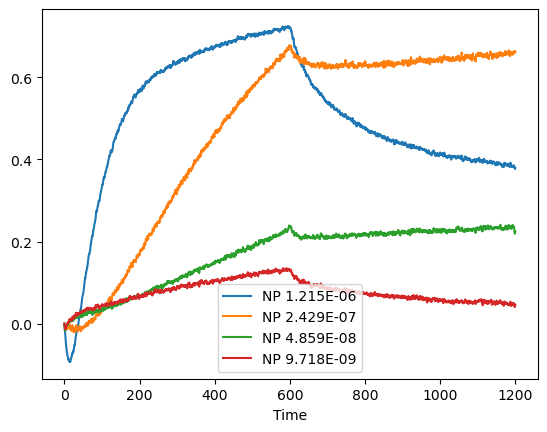

In [7]:
# plot the selected curves
if len(indices_list) > 0:
    pd.concat([bli_data['Time'],bli_data.iloc[:,indices_list]],axis=1).plot(x='Time')
else:
    pd.concat([bli_data['Time'],bli_data.iloc[:,start_index:end_index]],axis=1).plot(x='Time')

In [8]:
# find out where dissociation phase starts by looking for a gap in the timeseries data from inter-step correction
for i in range(len(bli_data.iloc[:,0])-1):
    # all data points will have ~0.2s between them, so find where there is >1s gap in time
    if bli_data.iloc[i+1,0] > bli_data.iloc[i,0]+1:
        x_end_assoc = bli_data.iloc[i,0]
        x_end_index = i

col_list = bli_data.columns

if len(indices_list) > 0:
    prot_conc_list = [float(i.partition('NP ')[2]) for i in col_list[indices_list]]
else:
    prot_conc_list = [float(i.partition('NP ')[2]) for i in col_list[start_index:end_index]]

x_data = bli_data.iloc[:,0].to_numpy()
# y_full_array = np.transpose(bli_data.iloc[:,1:].to_numpy())
if len(indices_list) > 0:
    y_array = np.transpose(bli_data.iloc[:,indices_list].to_numpy())
else:
    y_array = np.transpose(bli_data.iloc[:,start_index:end_index].to_numpy())

max_y = np.max(y_array)

In [9]:
# create a model from the association and dissociation function
assoc_dissoc_model = Model(biphasic_assoc_dissoc)

# choose some reasonable initial guesses and boundaries for the parameters
assoc_dissoc_model.set_param_hint('coef_A', value=0.5, min=0, max=1)
assoc_dissoc_model.set_param_hint('k_off1', value=0.001, min=1.0E-6, max=0.1)
assoc_dissoc_model.set_param_hint('k_off2', value=0.001, min=1.0E-6, max=0.1)
assoc_dissoc_model.set_param_hint('k_on1', value=1.0E4, min=1, max=1.0E9)
assoc_dissoc_model.set_param_hint('k_on2', value=1.0E4, min=1, max=1.0E9)

for i in range(len(prot_conc_list)):
    assoc_dissoc_model.set_param_hint(f'B{i+1}', value=max_y*2, min=0, max=2)

for i in range(6-len(prot_conc_list)):
    assoc_dissoc_model.set_param_hint(f'B{6-i}', value=0, vary=False)

fitting_params = assoc_dissoc_model.make_params()

# print out the parameters
fitting_params.pretty_print()

Name       Value      Min      Max   Stderr     Vary     Expr Brute_Step
B1          1.45        0        2     None     True     None     None
B2          1.45        0        2     None     True     None     None
B3          1.45        0        2     None     True     None     None
B4          1.45        0        2     None     True     None     None
B5             0     -inf      inf     None    False     None     None
B6             0     -inf      inf     None    False     None     None
coef_A       0.5        0        1     None     True     None     None
k_off1     0.001    1e-06      0.1     None     True     None     None
k_off2     0.001    1e-06      0.1     None     True     None     None
k_on1      1e+04        1    1e+09     None     True     None     None
k_on2      1e+04        1    1e+09     None     True     None     None


In [10]:
# use the Nelder-Mead fit as a "warm-start" for least squares
init_fit = assoc_dissoc_model.fit(y_array.flatten() , x=x_data, method='Nelder')

# try different fits starting with the parameter value outputs of the first fit
# fit2 = assoc_dissoc_model.fit(y_array.flatten(), x=x_data, params=init_fit.params, method='Nelder')
# fit2 = assoc_dissoc_model.fit(y_array.flatten(), x=x_data, params=init_fit.params, method='basinhopping')
fit2 = assoc_dissoc_model.fit(y_array.flatten(), x=x_data, params=init_fit.params, method='leastsquares')

# choose best fit
final_fit = fit2

# store the names of the fits that were used to be reported. If more than two fits are necessary, add them here.
# Make sure that final_fit is the last fit performed.
methods_used = f'{init_fit.method}, {fit2.method}' # {fit3.method}'

In [11]:
## print the results of the fit
fit_text = final_fit.fit_report()
print(fit_text)

[[Model]]
    Model(biphasic_assoc_dissoc)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 20000
    # data points      = 23972
    # variables        = 9
    chi-square         = 91.5397130
    reduced chi-square = 0.00382004
    Akaike info crit   = -133454.952
    Bayesian info crit = -133382.191
    R-squared          = 0.93280210
##  Warning: uncertainties could not be estimated:
    k_off2:  at boundary
    B4:      at boundary
[[Variables]]
    coef_A:  0.17277799 (init = 0.504402)
    k_off1:  0.00767609 (init = 0.0006383344)
    k_off2:  1.0000e-06 (init = 3.590796e-06)
    k_on1:   103.484223 (init = 6757.522)
    k_on2:   6745.22432 (init = 7472.51)
    B1:      0.74385882 (init = 0.6136499)
    B2:      1.32120525 (init = 1.09176)
    B3:      1.65264385 (init = 1.343106)
    B4:      1.99998507 (init = 1.938665)
    B5:      0 (fixed)
    B6:      0 (fixed)


In [12]:
# export fit info
# open(f'{folder_path}{title}.txt', 'w').close()
with open(f'{folder_path}{title}_result.txt', 'w') as f:
    f.writelines(fit_text)

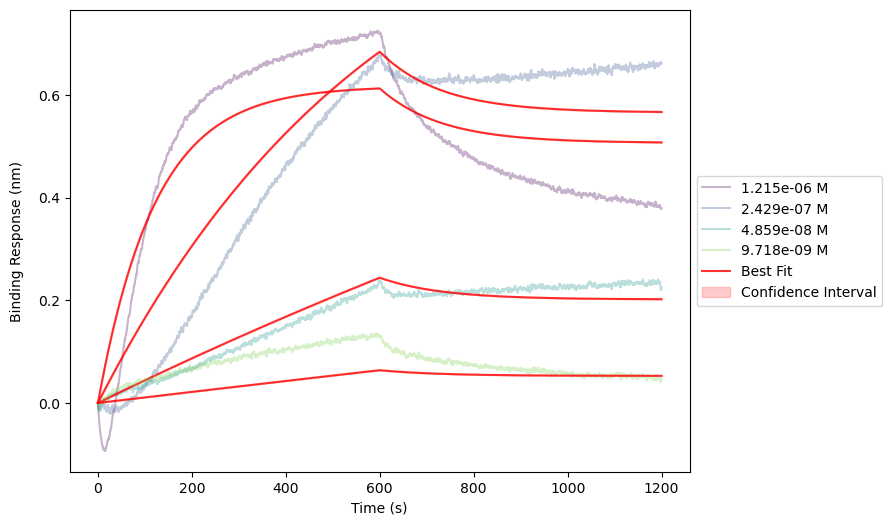

In [13]:
# determine the confidence bands for the curves. Set the +/- sigma for error bands.
del_y   = final_fit.eval_uncertainty(sigma=3) # plot 3-sigma = 99.7% confidence interval
y_fit   = final_fit.best_fit
y_lower = y_fit-del_y
y_upper = y_fit+del_y

# reshape the arrays from 1D back into 2D (the same shape they were in initially)
y_fit_array   = y_fit.reshape((len(prot_conc_list),len(x_data)))
y_lower_array = y_lower.reshape((len(prot_conc_list),len(x_data)))
y_upper_array = y_upper.reshape((len(prot_conc_list),len(x_data)))

# plot the raw and fitted data
fig, ax = plt.subplots(1,1, figsize=(8,6),dpi=100)

ax.set_ylabel('Binding Response (nm)', labelpad=10)
ax.set_xlabel('Time (s)')

n_lines = y_array.shape[0]
colors  = plt.cm.viridis(np.linspace(0, 0.8, n_lines))
legend_indices = []

# plot raw data
for i in range(n_lines):
    ax.plot(x_data, y_array[i,:], label=f'{prot_conc_list[i]} M', alpha=0.3, color=colors[i])
    ax.plot(x_data, y_fit_array[i,:], label='Best Fit', c='red', alpha=0.8)
    ax.fill_between(x_data, y_lower_array[i,:], y_upper_array[i,:], label='Confidence Interval', color='red', alpha=0.2)
    legend_indices.append(i*3)

legend_indices.append((n_lines-1)*3+1)
legend_indices.append((n_lines-1)*3+2)
handles, labels = ax.get_legend_handles_labels()

labels_set = [labels[i] for i in legend_indices]
handles_set = [handles[i] for i in legend_indices]
labels.append('confidence interval')
ax.legend(handles_set, labels_set, loc='center left', bbox_to_anchor=(1, 0.5), frameon=True)

# save the fit plot
plt.savefig(f'{folder_path}{title}_figure.pdf', format='pdf', bbox_inches='tight')

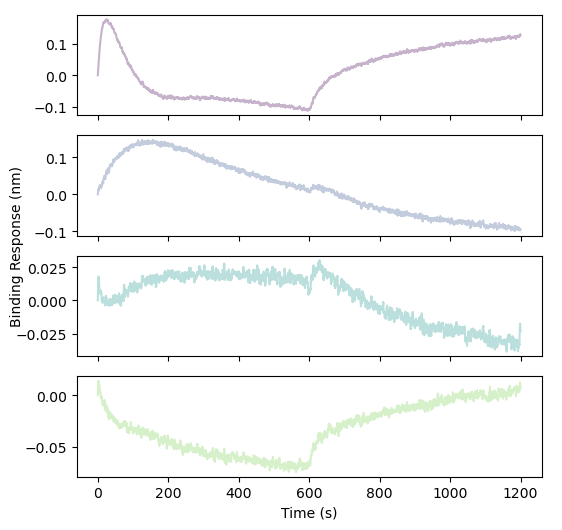

In [14]:
# plot the residuals
num_subplot = y_array.shape[0]
fig, ax = plt.subplots(num_subplot,1, figsize=(6,6),dpi=100, sharex=True)

# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Time (s)")
plt.ylabel("Binding Response (nm)", labelpad=15)

residuals = final_fit.residual.reshape((len(prot_conc_list),len(x_data)))

for i in range(num_subplot):
    ax[i].plot(x_data, residuals[i,:], color=colors[i], alpha=0.3)

# save the residuals plot
plt.savefig(f'{folder_path}{title}_residuals.pdf', format='pdf', bbox_inches='tight')

In [15]:
### export the parameter information as an excel sheet ### 

# calculate overall R-Squared 
# first, calculate variance in the array of residuals (sum of squares for residuals)
SSR    = residuals.var(axis=1) 
# calculate variance in the array of y values (sum of squares total)
SST    = y_array.var(axis=1)
# report R-squared and chi-squared
R_sq   = 1-sum(SSR)/sum(SST)
chi_sq = final_fit.chisqr

# get the initial values for the fit
coef_A_init = fitting_params['coef_A'].value
k_on1_init  = fitting_params['k_on1'].value
k_on2_init  = fitting_params['k_on2'].value
k_off1_init = fitting_params['k_off1'].value
k_off2_init = fitting_params['k_off2'].value

# get the fitted values
coef_A_fit = final_fit.params['coef_A'].value
k_on1_fit  = final_fit.params['k_on1'].value
k_on2_fit  = final_fit.params['k_on2'].value
k_off1_fit = final_fit.params['k_off1'].value
k_off2_fit = final_fit.params['k_off2'].value

# get the errors
coef_A_err = final_fit.params['coef_A'].stderr
k_on1_err  = final_fit.params['k_on1'].stderr
k_on2_err  = final_fit.params['k_on2'].stderr
k_off1_err = final_fit.params['k_off1'].stderr
k_off2_err = final_fit.params['k_off2'].stderr

# set up a dataframe to export parameter information
col_names = ['fit_methods', 'R2', 'chi2', 'A_init', 'A_wt', 'A_err', 'B_init', 'B_wt', 'B_err', 
             'k_on1_init', 'k_on1', 'k_on1_err', 'k_on2_init', 'k_on2', 'k_on2_err', 
             'k_off1_init', 'k_off1', 'k_off1_err', 'k_off2_init', 'k_off2', 'k_off2_err']

indices   = ['values']

values    = [methods_used, R_sq, chi_sq, coef_A_init, coef_A_fit, coef_A_err, 1-coef_A_init, 1-coef_A_fit, coef_A_err, 
             k_on1_init, k_on1_fit, k_on1_err, k_on1_init, k_on2_fit, k_on2_err, 
             k_off1_init, k_off1_fit, k_off1_err, k_off2_init, k_off2_fit, k_off2_err]

out_array = [values]

output_excel = pd.DataFrame(out_array, columns=col_names, index=indices)

# save the fit info data and the plotted fit
output_excel.to_excel(f'{folder_path}{title}_param_values.xlsx')

output_excel

,fit_methods,R2,chi2,A_init,A_wt,A_err,B_init,B_wt,B_err,k_on1_init,...,k_on1_err,k_on2_init,k_on2,k_on2_err,k_off1_init,k_off1,k_off1_err,k_off2_init,k_off2,k_off2_err
values,"Nelder-Mead, leastsq",0.841241,91.539713,0.5,0.172778,None,0.5,0.827222,None,10000.0,...,None,10000.0,6745.224316,None,0.001,0.007676,None,0.001,0.000001,None
